In [ ]:
#matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
from torch.utils import data
import pandas as pd, os, torch, torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torchvision.models as models

def predict_and_save(net, test_csv, id2name_path, output_csv, batch_size=64, device=None):
    # 1) 设备设定
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()

    # 2) 读取并兼容 id2name（可能是 dict/list/tensor）
    id2name_raw = torch.load(id2name_path)
    # 统一为 dict[int->str]
    if isinstance(id2name_raw, dict):
        id2name = {int(k): str(v) for k, v in id2name_raw.items()}
    elif isinstance(id2name_raw, (list, tuple)):
        id2name = {i: str(v) for i, v in enumerate(id2name_raw)}
    else:
        # 可能保存了numpy array/tensor
        try:
            arr = list(id2name_raw)
            id2name = {i: str(v) for i, v in enumerate(arr)}
        except Exception:
            raise ValueError("无法识别的 id2name 格式，请检查 label_decoder.pt 内容。")

    # 3) 读取测试文件与数据集
    test_df = pd.read_csv(test_csv)
    test_ds = ImageTest(test_csv, transform=T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),                      # 关键：PIL → tensor
                T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
        ]))
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    # 4) 预测循环（更稳健：处理 DataLoader 返回 tuple 或 tensor）
    preds = []
    with torch.no_grad():
        for batch in test_loader:
            # batch 可能是 tensor (B,C,H,W) 或 (tensor, something). 只取第一个元素如果是 tuple/list
            if isinstance(batch, (list, tuple)):
                x = batch[0]
            else:
                x = batch
            x = x.to(device)
            out = net(x)
            # 如果模型输出 logits/probs -> 取 argmax
            if out.dim() == 1:
                # 退化情况
                raise RuntimeError("模型输出维度异常，期望 (B, num_classes)。")
            y_pred = out.argmax(dim=1).cpu().numpy()
            preds.extend(y_pred.tolist())

    # 5) 长度校验
    if len(preds) != len(test_df):
        # 给出有用的诊断信息
        raise RuntimeError(f"预测数量({len(preds)})与测试样本数({len(test_df)})不一致。"
                           "请检查 test_csv 中行数与 ImageTest 的读取是否一致，"
                           "以及 DataLoader 是否按预期返回了所有样本。")

    # 6) 解码数字标签到字符串标签（容错）
    decoded = []
    for p in preds:
        key = int(p)
        if key in id2name:
            decoded.append(id2name[key])
        else:
            # 如果没有对应，放一个占位并提示
            decoded.append(f"UNK_{key}")

    # 7) 将结果写入 CSV：保持原 test_csv 的列顺序（例如含 'image' 列）
    # 尝试自动找到用于提交的路径列名（常见 'image'/'path'/'img'）
    possible_path_cols = ['image', 'path', 'img', 'filename']
    path_col = None
    for c in possible_path_cols:
        if c in test_df.columns:
            path_col = c
            break
    if path_col is None:
        # 若找不到，直接把第一列作为路径列
        path_col = test_df.columns[0]

    out_df = pd.DataFrame({path_col: test_df[path_col], 'label': decoded})
    out_df.to_csv(output_csv, index=False)
    print(f"已生成 {output_csv}，共 {len(decoded)} 条预测记录。")

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
    
class ImageTrain(Dataset):
    """CSV 里只有两列：path, label"""
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)          # 支持 excel 就 pd.read_excel
        self.transform = transform
        self.encoder = LabelEncoder()
        self.df['label'] = self.encoder.fit_transform(self.df['label'])
        self.id2name = dict(enumerate(self.encoder.classes_))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]          # 第一列：图片路径
        label    = self.df.iloc[idx, 1].item()           # 第二列：标签
        image = Image.open('D:/kaggle/data/classifyleaves/' + img_path).convert('RGB')   # 灰度图也转成 3 通道
        if self.transform:
            image = self.transform(image)
        return image, label
    
class ImageTest(Dataset):
    """CSV 里只有两列：path, label"""
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)          # 支持 excel 就 pd.read_excel
        self.transform = transform
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]          # 第一列：图片路径
        image = Image.open('D:/kaggle/data/classifyleaves/' + img_path).convert('RGB')   # 灰度图也转成 3 通道
        if self.transform:
            image = self.transform(image)
        return image
    

def train_ch6(net, train_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))

    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    

def load_data(batch_size, resize=None):

    transform = T.Compose([
            T.RandomResizedCrop(224, scale=(0.7, 1.0)),  # 随机缩放+裁剪
            T.RandomHorizontalFlip(p=0.5),               # 50% 水平翻转
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 色彩扰动
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

    # 4. 构建 DataLoader
    train_csv = 'D:/kaggle/data/classifyleaves/train.csv'    # 你的 excel 另存为 csv 即可
    # test_csv  = 'D:/kaggle/data/classifyleaves/test.csv'

    train_ds = ImageTrain(train_csv, transform=transform)
    torch.save(train_ds.id2name, 'label_decoder.pt')   # 保存映射
    # test_ds   = CsvImageDataset(test_csv,   transform=transform, train_ = False)

    return data.DataLoader(train_ds, batch_size, shuffle=True,num_workers=0)

# b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
#                    nn.BatchNorm2d(64), nn.ReLU(),
#                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# def resnet_block(input_channels, num_channels, num_residuals,
#                  first_block = False):
#     blk = []
#     for i in range(num_residuals):
#         if i == 0 and not first_block:
#             blk.append(Residual(input_channels, num_channels,
#                                 use_1x1conv=True, strides=2))
#         else:
#             blk.append(Residual(num_channels, num_channels))
    
#     return blk

# b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
# b3 = nn.Sequential(*resnet_block(64, 128, 2))
# b4 = nn.Sequential(*resnet_block(128, 256, 2))
# b5 = nn.Sequential(*resnet_block(256, 512, 2))

# net = nn.Sequential(b1, b2, b3, b4, b5,
#                     nn.AdaptiveAvgPool2d((1,1)),
#                     nn.Flatten(),
#                     nn.Linear(512, 176))




KeyboardInterrupt: 

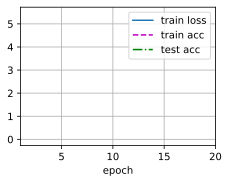

In [ ]:

net = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
net.fc = torch.nn.Linear(net.fc.in_features, 176)

lr, num_epochs, batch_size = 0.001, 20, 64
train_iter = load_data(batch_size)
train_ch6(net, train_iter, num_epochs, lr, d2l.try_gpu())


predict_and_save(net,
                 test_csv='D:/kaggle/data/classifyleaves/test.csv',
                 id2name_path='label_decoder.pt',
                 output_csv='D:/kaggle/data/classifyleaves/submission.csv',
                 batch_size=64)

